# SuperflexPy example 07: Create a new reservoir

Author: Marco Dal Molin

Collaborators: Fabrizio Fenicia, Dmitri Kavetski

## What's in this example

This example will cover the following aspects:
- [Expand the framework creating a new reservoir](https://superflexpy.readthedocs.io/en/latest/build_element.html#linear-reservoir)

By clicking on the items you will be redirected to the documentation page (when available) that explains the arguments in a more detailed way. 

## What's not in this example

The following aspects are already covered in other examples:

- [Initialize the new element](./03_init_single_element_model.ipynb)
- [Run the element](./01_run_simple_model.ipynb)

For this reason we will put only the code need, without further explanations. You can check the other examples by clicking on the items above.

## Do you want to use this example as a script?

Examples of SuperflexPy are created and distributed using Jupyter notebooks because they enable to conjugate runnable code with text explanations. We have decided to not provide the content of the notebooks as script because this would mean duplicating the same content in multiple places, bringing to maintainability problems.

If the user wants to download the content of this notebook as a python script, it is possible following the steps:
1. If not already done, open this notebook using [Binder](https://mybinder.org/v2/gh/dalmo1991/superflexPy/master?filepath=examples%2F07_create_reservoir.ipynb)
2. Go on File -> Download as -> Python (.py)
3. Select the saving path

The result is a Python script that contains all the markdown text as comment and the code contained inside the cells.

## STEP 0: Import of external libraries

The execution of the code in this example relies on the following external libraries:
- **numpy**: arrays handling
- **numba**: runtime compiler

We assume that those libraries are already installed together with the latest version of SuperflexPy. Keep in mind that not all the libraries listed above are strictly needed to execute SuperflexPy and, therefore, they are not listed as requirements of SuperflexPy.

In [1]:
import numpy as np
import numba as nb

## STEP 1: Define the problem

The element is controlled by the following differential equation
$$\frac{\textrm{d}S}{\textrm{d}t}=P-Q$$

with
$$Q=kS$$

The solution of the differential equation can be approximated using a numerical method with the equation that, in the general case, becomes:
$$\frac{S_{t+1} - S_{t}}{\Delta t}=P - Q(S)$$

Several numerical methods exist to approximate the solution of the differential equation and, usually, they differ for the state used to evaluate the fluxes: implicit Euler, for example, uses the state at the end of the time step $S_{t+1}$
$$\frac{S_{t+1} - S_{t}}{\Delta t}=P - kS_{t+1}$$

explicit Euler uses the state at the beginning of the time step $S_t$
$$\frac{S_{t+1} - S_{t}}{\Delta t}=P - kS_{t}$$

and so on for other methods.

Note that, even if for this simple case the differential equation can be solved analytically and the solution of the numerical approximation can be found without iteration, we will use anyway the numerical solver offered by SuperflexPy to illustrate how to proceed in a more general case where such option is not available.

## STEP 2: Implement the element

### 01. Import the packages od SuperflexPy needed

- `superflexpy.framework.element.ODEsElement` class to inherit from

In [2]:
from superflexpy.framework.element import ODEsElement

### 02. Implement the class LinearReservoir

This requires to override 4 (5 with the numba optimization) methods:
- `__init__`
- `set_input`
- `get_output`
- `_fluxes_function_python`
- `_fluxes_function_numba`

In [3]:
class LinearReservoir(ODEsElement):
    """
    This class implements a simple linear reservoir.

    Parameters
    ----------
    parameters : dict
        Parameters of the element. The keys must be:
            - k : multiplier of the state
    states : dict
            Initial state of the element. The keys must be:
            - 'S0' : initial storage of the reservoir.
    approximation : superflexpy.utils.numerical_approximation.NumericalApproximator
        Numerial method used to approximate the differential equation
    id : str
        Itentifier of the element. All the elements of the framework must
        have an id.
    """
    
    def __init__(self, parameters, states, approximation, id):

        ODEsElement.__init__(self,
                             parameters=parameters,
                             states=states,
                             approximation=approximation,
                             id=id)

        self._fluxes_python = [self._fluxes_function_python]  # Used by get fluxes, regardless of the architecture

        if approximation.architecture == 'numba':
            self._fluxes = [self._fluxes_function_numba]
        elif approximation.architecture == 'python':
            self._fluxes = [self._fluxes_function_python]
        else:
            message = '{}The architecture ({}) of the approximation is not correct'.format(self._error_message,
                                                                                           approximation.architecture)
            raise ValueError(message)
            
    def set_input(self, input):
        """
        Set the input of the element.

        Parameters
        ----------
        input : list(numpy.ndarray)
            List containing the input fluxes of the element. It contains 1
            flux:
            1. Rainfall
        """
        
        self.input = {'P': input[0]}
        
    def get_output(self, solve=True):
        """
        This method solves the differential equation governing the routing
        store.

        Returns
        -------
        list(numpy.ndarray)
            Output fluxes in the following order:
            1. Streamflow (Q)
        """
        
        if solve:
            self._solver_states = [self._states[self._prefix_states + 'S0']]
            self._solve_differential_equation()

            self.set_states({self._prefix_states + 'S0': self.state_array[-1, 0]})

        fluxes = self._num_app.get_fluxes(fluxes=self._fluxes_python,
                                          S=self.state_array,
                                          S0=self._solver_states,
                                          dt=self._dt,
                                          **self.input,
                                          **{k[len(self._prefix_parameters):]: self._parameters[k] for k in self._parameters},
                                          )

        return [- fluxes[0][1]]

    @staticmethod
    def _fluxes_function_python(S, S0, ind, P, k, dt):

        if ind is None:
            return (
                [
                    P,
                    - k * S,
                ],
                0.0,
                S0 + P * dt
            )
        else:
            return (
                [
                    P[ind],
                    - k[ind] * S,
                ],
                0.0,
                S0 + P[ind] * dt[ind],
                [
                    0.0,
                    - k[ind]
                ]
            )

    @staticmethod
    @nb.jit('Tuple((UniTuple(f8, 2), f8, f8, UniTuple(f8, 2)))(optional(f8), f8, i4, f8[:], f8[:], f8[:])',
            nopython=True)
    def _fluxes_function_numba(S, S0, ind, P, k, dt):

        return (
            (
                P[ind],
                - k[ind] * S,
            ),
            0.0,
            S0 + P[ind] * dt[ind],
            (
                0.0,
                - k[ind]
            )
        )

## STEP 3: Initialize and run the model

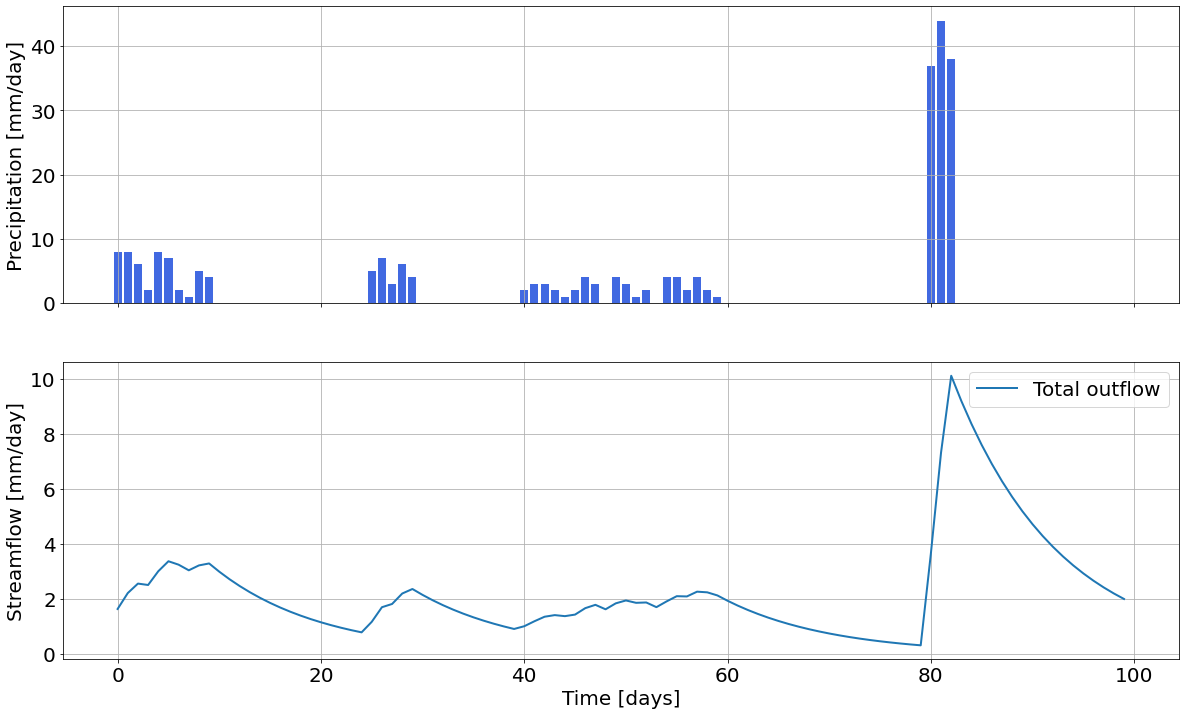

In [4]:
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

root_finder = PegasusPython()
numeric_approximator = ImplicitEulerPython(root_finder=root_finder)

lr = LinearReservoir(
    parameters={'k': 0.1},
    states={'S0': 10.0},
    approximation=numeric_approximator,
    id='LR'
)

# Fix the seed
SEED = 2
rng = np.random.RandomState(seed=SEED)

# Generate the input
P = np.zeros(100)
P[:10] = rng.randint(10, size=10)
P[25:30] = rng.randint(20, size=5)
P[40:60] = rng.randint(5, size=20)
P[80:83] = rng.randint(30, 50, size=3)

# Assign the input
lr.set_input([P])

# Set the timestep
lr.set_timestep(1.0)

# Run the model
output = lr.get_output()

# Plot
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax[0].set_ylabel('Precipitation [mm/day]')
ax[0].grid(True)
ax[1].plot(np.arange(len(P)), output[0], lw=2, label='Total outflow')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('Streamflow [mm/day]')
ax[1].legend()
ax[1].grid(True)
pass